In [57]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime
from scipy.io import loadmat

In [58]:
# Read the Excel file
file_name = 'Data_4_Import_REST.xlsx'
excel_sheet_name = 'Depression Rest'
file_path = os.path.join("Depression_Study", "depression_data", file_name)
df_raw = pd.read_excel(file_path, sheet_name=excel_sheet_name)

# Extract healthy and depressed samples
healthy_sample = df_raw[df_raw.iloc[:, 1] == 99].iloc[:, 0].tolist()
depressed_sample = df_raw[df_raw.iloc[:, 1] != 99].iloc[:, 0].tolist()

In [59]:
# Load CSER values from MAT file
cser_values = loadmat("cser_values.mat")

# Extract field names from cser_open and cser_closed
field_names_open = [int(name[1:]) for name in cser_values['cser_open'].dtype.names]
field_names_closed = [int(name[1:]) for name in cser_values['cser_closed'].dtype.names]

# Extract values from the CSER data
cser_open = np.array([value[0][0] for sublist in cser_values['cser_open'][0] for value in sublist])
cser_closed = np.array([value[0][0] for sublist in cser_values['cser_closed'][0] for value in sublist])

# Extract band values into separate list for each band
cser_band_open = [np.array([value[0][i] for sublist in cser_values['cser_band_open'][0] for value in sublist]) for i in range(6)]
cser_band_closed = [np.array([value[0][i] for sublist in cser_values['cser_band_closed'][0] for value in sublist]) for i in range(6)]

# Extract CSER from the for each of the 60 sources
cser_source_open = [np.array([value[0][i] for sublist in cser_values['cser_source_open'][0] for value in sublist]) for i in range(60)]
cser_source_closed = [np.array([value[0][i] for sublist in cser_values['cser_source_closed'][0] for value in sublist]) for i in range(60)]

# Extract CSER from the for each of the 60 sources
cser_source_band_open = np.array([[np.array([value[j][i] for sublist in cser_values['cser_source_band_open'][0] for value in sublist]) for i in range(60)] for j in range(6)])
cser_source_band_closed = np.array([[np.array([value[j][i] for sublist in cser_values['cser_source_band_closed'][0] for value in sublist]) for i in range(60)] for j in range(6)])
# i source x j band

# Extract AAL source names
source_names = [(cser_values['source_names'][i][0][0]) for i in range(60)]

In [ ]:
# print(df_raw.columns.tolist())
df = df_raw.copy()
df = df.drop(columns=['MDD_note', 'HamD'])
# print(df.columns.tolist())

missing_ids_open = set(df['id']) - set(field_names_open)
df = df[~df['id'].isin(missing_ids_open)]

df['eyes'] = 'open'
df['area'] = 'brain'
df['band'] = 'broadband'
df['CSER'] = np.nan

# df['depressed'] = df.iloc[:, 1].apply(lambda x: 1 if x != 99 else 0)
df['depressed'] = df.iloc[:, 1].apply(lambda x: 1 if x == 1 else 0)

# Reorder columns: insert ['eyes', 'area', 'band', 'CSER'] after 'id'
cols = df.columns.tolist()
insert_cols = ['eyes', 'area', 'band', 'CSER']
# Remove if already present to avoid duplication
for c in insert_cols:
    if c in cols:
        cols.remove(c)
id_idx = cols.index('id')
new_cols = cols[:id_idx+1] + insert_cols + cols[id_idx+1:]
df = df[new_cols]

print(df.columns.tolist())
print()

df_copy = df.copy()

print("DF Shape:", df.shape)

# OPEN / BRAIN / BROADBAND
for i, row in df.iterrows():
    id_value = row['id']
    if id_value in field_names_open:
        df.at[i, 'CSER'] = cser_open[field_names_open.index(id_value)]

print("DF Shape after inserting [open / brain / broadband]:", df.shape)

# CLOSED / BRAIN / BROADBAND
df_closed = df_copy.copy()
df_closed['eyes'] = 'closed'
df_closed['area'] = 'brain'
df_closed['band'] = 'broadband'
# Add CSER values for closed eyes
for i, row in df_closed.iterrows():
    id_value = row['id']
    if id_value in field_names_closed:
        df_closed.at[i, 'CSER'] = cser_closed[field_names_closed.index(id_value)]
df = pd.concat([df, df_closed], ignore_index=True)

print("DF Shape after inserting [closed / brain / broadband]:", df.shape)

# open / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
# band_names = ["1-4","4-8","8-12","12-30","30-100"]
band_names = ["1-4","4-8","8-12","12-30","30-100","1-12"]
for i, band in enumerate(band_names):
    df_band = df_copy.copy()
    df_band['eyes'] = 'open'
    df_band['area'] = 'brain'
    df_band['band'] = band
    for j, row in df_band.iterrows():
        id_value = row['id']
        if id_value in field_names_open:
            data_index = field_names_open.index(id_value)
            df_band.at[j, 'CSER'] = cser_band_open[i][data_index]
    df = pd.concat([df, df_band], ignore_index=True)

print("DF Shape after inserting [open / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# closed / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
for i, band in enumerate(band_names):
    df_band = df_copy.copy()
    df_band['eyes'] = 'closed'
    df_band['area'] = 'brain'
    df_band['band'] = band
    for j, row in df_band.iterrows():
        id_value = row['id']
        if id_value in field_names_closed:
            data_index = field_names_closed.index(id_value)
            df_band.at[j, 'CSER'] = cser_band_closed[i][data_index]
    df = pd.concat([df, df_band], ignore_index=True)

print("DF Shape after inserting [closed / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# open / src01, src02, ..., src60 / broadband
for i in range(60):
    df_source = df_copy.copy()
    df_source['eyes'] = 'open'
    df_source['area'] = f'src{i+1:02d}_{source_names[i]}'
    df_source['band'] = 'broadband'
    for j, row in df_source.iterrows():
        id_value = row['id']
        if id_value in field_names_open:
            data_index = field_names_open.index(id_value)
            df_source.at[j, 'CSER'] = cser_source_open[i][data_index]
    df = pd.concat([df, df_source], ignore_index=True)

print("DF Shape after inserting [open / src01, src02, ..., src60 / broadband]:", df.shape)

# closed / src01, src02, ..., src60 / broadband
for i in range(60):
    df_source = df_copy.copy()
    df_source['eyes'] = 'closed'
    df_source['area'] = f'src{i+1:02d}_{source_names[i]}'
    df_source['band'] = 'broadband'
    for j, row in df_source.iterrows():
        id_value = row['id']
        if id_value in field_names_closed:
            data_index = field_names_closed.index(id_value)
            df_source.at[j, 'CSER'] = cser_source_closed[i][data_index]
    df = pd.concat([df, df_source], ignore_index=True)

print("DF Shape after inserting [closed / src01, src02, ..., src60 / broadband]:", df.shape)

# open / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
for i in range(60):
    for j, band in enumerate(band_names):
        df_source_band = df_copy.copy()
        df_source_band['eyes'] = 'open'
        df_source_band['area'] = f'src{i+1:02d}_{source_names[i]}'
        df_source_band['band'] = band
        for k, row in df_source_band.iterrows():
            id_value = row['id']
            if id_value in field_names_open:
                data_index = field_names_open.index(id_value)
                df_source_band.at[k, 'CSER'] = cser_source_band_open[j][i][data_index]
        df = pd.concat([df, df_source_band], ignore_index=True)

print("DF Shape after inserting [open / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# closed / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
for i in range(60):
    for j, band in enumerate(band_names):
        df_source_band = df_copy.copy()
        df_source_band['eyes'] = 'closed'
        df_source_band['area'] = f'src{i+1:02d}_{source_names[i]}'
        df_source_band['band'] = band
        for k, row in df_source_band.iterrows():
            id_value = row['id']
            if id_value in field_names_closed:
                data_index = field_names_closed.index(id_value)
                df_source_band.at[k, 'CSER'] = cser_source_band_closed[j][i][data_index]
        df = pd.concat([df, df_source_band], ignore_index=True)

print("DF Shape after inserting [closed / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# open, closed / frontal, occipital, parietal, sensorimotor, temporal / broadband, 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
region_map = {
    'frontal': [f'src{i+1:02d}_{source_names[i]}' for i in range(2, 16)] + [f'src{i:02d}_{source_names[i]}' for i in range(18, 24)],
    'occipital': [f'src{i+1:02d}_{source_names[i]}' for i in range(24, 36)],
    'parietal': [f'src{i+1:02d}_{source_names[i]}' for i in range(38, 50)],
    'sensorimotor': [f'src{i+1:02d}_{source_names[i]}' for i in [0, 1, 16, 17, 36, 37]],
    'temporal': [f'src{i+1:02d}_{source_names[i]}' for i in range(50, 60)]
}

def map_region(area):
    for region, sources in region_map.items():
        if area in sources:
            return region
    return area

df_avg = df[df['area'] != 'brain'].copy()
df_avg['area'] = df_avg['area'].apply(map_region)
group_cols = ['id', 'eyes', 'area', 'band']
agg_dict = {col: 'first' for col in df_avg.columns if col not in group_cols + ['CSER']}
agg_dict['CSER'] = 'mean'
df_avg = df_avg.groupby(group_cols, as_index=False).agg(agg_dict)
df = pd.concat([df, df_avg], ignore_index=True)

print("DF Shape after inserting [open, closed / frontal, ..., temporal / broadband, 1-4, ..., 30-100, 1-12]:", df.shape)

# open / brain, frontal, ..., src60 / 1_12m  # mean estimate for 1-12 band
# df_temp = df.copy()
# df_temp = df_temp[~df_temp['band'].isin(['broadband', '12-30', '30-100'])]
# df_temp['band'] = '1-12m'

# group_cols = ['id', 'eyes', 'area', 'band']
# agg_dict = {col: 'first' for col in df_temp.columns if col not in group_cols + ['CSER']}
# agg_dict['CSER'] = 'mean'
# df_temp = df_temp.groupby(group_cols, as_index=False).agg(agg_dict)
# df = pd.concat([df, df_temp], ignore_index=True)

# print("DF Shape after inserting [open / brain, frontal, ..., src60 / 1-12m]:", df.shape)

# sort 'band' column as per the specified order
band_order = ['broadband', '1-12', '1-4', '4-8', '8-12', '12-30', '30-100']
df['band'] = pd.Categorical(df['band'], categories=band_order, ordered=True)

df = df.sort_values(by=['id', 'eyes', 'area', 'band']).reset_index(drop=True)
print()
print(df)

['id', 'eyes', 'area', 'band', 'CSER', 'MDD', 'sex', 'age', 'BDI', 'BDI_Anh', 'BDI_Mel', 'TAI', 'depressed']

DF Shape: (119, 13)
DF Shape after inserting [open / brain / broadband]: (119, 13)
DF Shape after inserting [closed / brain / broadband]: (238, 13)
DF Shape after inserting [open / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (952, 13)
DF Shape after inserting [closed / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (1666, 13)
DF Shape after inserting [open / src01, src02, ..., src60 / broadband]: (8806, 13)
DF Shape after inserting [closed / src01, src02, ..., src60 / broadband]: (15946, 13)
DF Shape after inserting [open / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (58786, 13)
DF Shape after inserting [closed / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (101626, 13)
DF Shape after inserting [open, closed / frontal, ..., temporal / broadband, 1-4, ..., 30-100, 1-12]: (119952, 13)

         id    eyes      area       band      CSER  M

In [ ]:
# Identify CSER outliers using IQR method
def identify_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# outliers_df = identify_outliers_iqr(df, 'CSER')
# print(outliers_df)
# df = df[~df.index.isin(outliers_df.index)]

# Drop CUSTOM outliers from the DataFrame if they exist
outlier_ids = ['527','535']
# 527 > closed epochs (channels 2, 40, 54) behaves like a random walk according to MVGC
# 535 > open epochs are too noisy
ids_in_df = df['id'].astype(str).isin(outlier_ids)
if ids_in_df.any():
    df = df[~ids_in_df]
print("\nDropped outliers with IDs:", outlier_ids)


Dropped outliers with IDs: ['527', '535']


In [ ]:
df['depressed'] = df['MDD'].apply(lambda x: 1 if x == 1 else 0)
df['intercept'] = 1
df['age_squared'] = df['age'] ** 2
if df['sex'].max() == 2:
    df['sex'] = df['sex'] - 1

# Perform regression analysis for each combination of eyes, area, and band
variables = ['intercept', 'depressed', 'BDI', 'BDI_Anh', 'BDI_Mel', 'TAI', 'sex', 'age', 'age_squared']
rlm_results = pd.DataFrame(columns=['eyes', 'area', 'band', 'variable', 'p_value', 't_value', 'p_significant', 't_significant'])

for eyes in ['open', 'closed']:
    for area in df['area'].unique():
        for band in df['band'].unique():
            # Run sm.RLM for each subset of the DataFrame
            subset = df[(df['eyes'] == eyes) & (df['area'] == area) & (df['band'] == band)]
            if subset.empty:
                continue
            model = sm.RLM(subset['CSER'], subset[variables], missing='drop', M=sm.robust.norms.HuberT())
            results = model.fit()
            # print(results.summary())
            for var in variables[1:]:
                p_significant = results.pvalues[var] <= 0.05
                t_significant = abs(results.tvalues[var]) >= 1.7
                new_permutation = pd.DataFrame([{
                    'eyes': eyes,
                    'area': area,
                    'band': band,
                    'variable': var,
                    'p_value': results.pvalues[var],
                    't_value': results.tvalues[var],
                    'p_significant': p_significant,
                    't_significant': t_significant
                }])
                rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)

print(rlm_results)

C:\Users\lukad\AppData\Local\Temp\ipykernel_31488\512448008.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)


        eyes      area       band     variable   p_value   t_value  \
0       open     brain  broadband    depressed  0.894073 -0.133153   
1       open     brain  broadband          BDI  0.349518  0.935525   
2       open     brain  broadband      BDI_Anh  0.132802  1.503144   
3       open     brain  broadband      BDI_Mel  0.202435 -1.274644   
4       open     brain  broadband          TAI  0.407037 -0.829120   
...      ...       ...        ...          ...       ...       ...   
7387  closed  temporal     30-100      BDI_Mel  0.648347 -0.456060   
7388  closed  temporal     30-100          TAI  0.990009 -0.012523   
7389  closed  temporal     30-100          sex  0.292295  1.053101   
7390  closed  temporal     30-100          age  0.968504  0.039484   
7391  closed  temporal     30-100  age_squared  0.955016 -0.056409   

     p_significant t_significant  
0            False         False  
1            False         False  
2            False         False  
3            False 

## TEXT SUMMARIES

In [81]:
cser_mean_band_area = df.groupby(['eyes', 'depressed', 'band', 'area'], observed=True)['CSER'].mean().reset_index()
cser_mean_band_area_pivot = cser_mean_band_area.pivot_table(index=['eyes', 'depressed', 'band'], columns=['area'], values='CSER', observed=True)
print(cser_mean_band_area_pivot)

area                           brain   frontal  occipital  parietal  \
eyes   depressed band                                                 
closed 0         broadband  0.451924  0.622859   0.254698  0.280442   
                 1-12       0.196269  0.190904   0.199702  0.201241   
                 1-4        0.058303  0.060787   0.054992  0.056909   
                 4-8        0.066699  0.067408   0.064497  0.067318   
                 8-12       0.071267  0.062709   0.080213  0.077014   
                 12-30      0.199529  0.200773   0.191594  0.202789   
                 30-100     0.293506  0.419347   0.156639  0.165746   
       1         broadband  0.488240  0.664569   0.263164  0.317355   
                 1-12       0.194455  0.190083   0.195739  0.199674   
                 1-4        0.056895  0.059970   0.052266  0.055349   
                 4-8        0.064704  0.066335   0.060574  0.065484   
                 8-12       0.072855  0.063778   0.082898  0.078842   
      

In [93]:
df_brain = df[df['area'] == 'brain']
cser_mean_band = df_brain.groupby(['eyes', 'depressed', 'band'], observed=True)['CSER'].mean().reset_index()
cser_mean_band_pivot = cser_mean_band.pivot_table(index=['eyes', 'depressed'], columns=['band'], values='CSER', observed=True)
print(cser_mean_band_pivot)

band              broadband      1-12       1-4       4-8      8-12     12-30  \
eyes   depressed                                                                
closed 0           0.451924  0.196269  0.058303  0.066699  0.071267  0.199529   
       1           0.488240  0.194455  0.056895  0.064704  0.072855  0.204681   
open   0           0.546212  0.193484  0.059767  0.066370  0.067347  0.207106   
       1           0.586313  0.190699  0.058832  0.064747  0.067119  0.212001   

band                30-100  
eyes   depressed            
closed 0          0.293506  
       1          0.314836  
open   0          0.360459  
       1          0.384619  


In [92]:
df_broadband = df[df['band'] == 'broadband']
cser_mean_area = df_broadband.groupby(['eyes', 'depressed', 'area'])['CSER'].mean().reset_index()
cser_mean_area_pivot = cser_mean_area.pivot_table(index=['eyes', 'depressed'], columns=['area'], values='CSER')
print(cser_mean_area_pivot)

area                 brain   frontal  occipital  parietal  sensorimotor  \
eyes   depressed                                                          
closed 0          0.451924  0.622859   0.254698  0.280442      0.471954   
       1          0.488240  0.664569   0.263164  0.317355      0.518301   
open   0          0.546212  0.697580   0.424183  0.367411      0.539750   
       1          0.586313  0.739319   0.452223  0.416457      0.565433   

area              src01_Precentral_L  src02_Precentral_R  src03_Frontal_Sup_L  \
eyes   depressed                                                                
closed 0                    0.416555            0.412435             0.492580   
       1                    0.471047            0.416819             0.590951   
open   0                    0.505955            0.479196             0.585452   
       1                    0.501098            0.485806             0.632159   

area              src04_Frontal_Sup_R  src05_Frontal_Sup_Orb_L

In [70]:
# Print significant t-values for each variable, eyes, brain region, and band
regions = list(region_map.keys())

for var in variables:
    if var in ['intercept', 'age_squared']:
        continue
    for eyes in ['open', 'closed']:
        print(f"\nVariable: {var}, Eyes: {eyes}")
        significance_found = False
        for region in regions:
            region_results = rlm_results[
                (rlm_results['variable'] == var) &
                (rlm_results['eyes'] == eyes) &
                (rlm_results['area'] == region) &
                (rlm_results['t_significant'])
            ]
            if not region_results.empty:
                significance_found = True
                print(f"  Region: {region}")
                for _, row in region_results.iterrows():
                    print(f"    Band: {row['band']}, t-value: {row['t_value']:.3f}")
        if not significance_found:
            print("  (no significant regions / bands)")


Variable: depressed, Eyes: open
  (no significant regions / bands)

Variable: depressed, Eyes: closed
  Region: occipital
    Band: 1-4, t-value: -2.378
    Band: 8-12, t-value: 2.235
  Region: parietal
    Band: 1-4, t-value: -1.764
    Band: 8-12, t-value: 1.925

Variable: BDI, Eyes: open
  Region: frontal
    Band: 8-12, t-value: -2.198
  Region: occipital
    Band: 8-12, t-value: -1.783
  Region: parietal
    Band: broadband, t-value: 2.254
    Band: 1-12, t-value: -2.325
    Band: 8-12, t-value: -2.068
    Band: 30-100, t-value: 2.283
  Region: sensorimotor
    Band: 1-12, t-value: -2.535
    Band: 8-12, t-value: -1.709
  Region: temporal
    Band: 1-12, t-value: -1.996
    Band: 8-12, t-value: -1.980

Variable: BDI, Eyes: closed
  Region: frontal
    Band: 8-12, t-value: -1.830
  Region: parietal
    Band: 1-12, t-value: -1.816
    Band: 8-12, t-value: -2.077
  Region: sensorimotor
    Band: 1-12, t-value: -1.887
    Band: 8-12, t-value: -1.729

Variable: BDI_Anh, Eyes: open
  R

In [71]:
# Print all significant (t_significant) variables and bands for each region
for region in regions:
    print(f"\nRegion: {region}")
    region_results = rlm_results[
        (rlm_results['area'] == region) &
        (rlm_results['t_significant'] == True)
    ]
    if region_results.empty:
        print("  (no significant variables / bands)")
        continue
    for var in variables:
        if var in ['intercept', 'age_squared']:
            continue
        var_results = region_results[region_results['variable'] == var]
        if not var_results.empty:
            bands = var_results['band'].tolist()
            tvals = var_results['t_value'].tolist()
            print(f"  Variable: {var}")
            for band, tval in zip(bands, tvals):
                print(f"    Band: {band}, t-value: {tval:.3f}")


Region: frontal
  Variable: BDI
    Band: 8-12, t-value: -2.198
    Band: 8-12, t-value: -1.830
  Variable: BDI_Anh
    Band: 4-8, t-value: -2.273
    Band: 4-8, t-value: -1.915
  Variable: TAI
    Band: 8-12, t-value: 1.953
    Band: 1-12, t-value: 1.933
    Band: 8-12, t-value: 2.020
  Variable: sex
    Band: 8-12, t-value: -1.739
    Band: 12-30, t-value: -4.424
    Band: 1-12, t-value: -2.163
    Band: 4-8, t-value: -2.160
    Band: 8-12, t-value: -1.905
    Band: 12-30, t-value: -4.195
  Variable: age
    Band: 12-30, t-value: -2.088
    Band: 12-30, t-value: -2.230

Region: occipital
  Variable: depressed
    Band: 1-4, t-value: -2.378
    Band: 8-12, t-value: 2.235
  Variable: BDI
    Band: 8-12, t-value: -1.783
  Variable: BDI_Anh
    Band: broadband, t-value: 1.993
    Band: 30-100, t-value: 1.983
    Band: broadband, t-value: 2.013
    Band: 30-100, t-value: 2.180
  Variable: BDI_Mel
    Band: broadband, t-value: -1.737
  Variable: TAI
    Band: 1-4, t-value: -1.943
    Band

In [73]:
significant_results = pd.DataFrame(columns=['variable', 'value', 'count', 'percentage'])

def count_significant_results(df, column):
    counts = df[column].value_counts()
    total = len(df)
    percentages = (counts / total) * 100
    percentages = percentages.round(2)
    return counts, percentages

for var in ['eyes', 'area', 'band']:
    counts, percentages = count_significant_results(rlm_results[rlm_results['p_significant']], var)

    counts_df = counts.to_frame(name='count')
    percentages_df = percentages.to_frame(name='percentage')
    merged_df = pd.merge(counts_df, percentages_df, left_index=True, right_index=True)

    print(merged_df, "\n")
    
    merged_df = merged_df.reset_index().rename(columns={var: 'value'})
    merged_df['variable'] = var
    significant_results = pd.concat([significant_results, merged_df], ignore_index=True)

print(significant_results)

        count  percentage
eyes                     
closed    478       54.13
open      405       45.87 

                            count  percentage
area                                         
src21_Frontal_Sup_Medial_L     31        3.51
src19_Supp_Motor_Area_L        30        3.40
src22_Frontal_Sup_Medial_R     29        3.28
src39_Parietal_Sup_L           27        3.06
src20_Supp_Motor_Area_R        26        2.94
...                           ...         ...
src04_Frontal_Sup_R             6        0.68
src34_Occipital_Mid_R           6        0.68
src06_Frontal_Sup_Orb_R         5        0.57
src10_Frontal_Mid_Orb_R         5        0.57
src54_Temporal_Pole_Sup_R       4        0.45

[66 rows x 2 columns] 

           count  percentage
band                        
12-30        354       40.09
1-12         150       16.99
8-12         124       14.04
30-100        77        8.72
4-8           71        8.04
broadband     67        7.59
1-4           40        4.53 

   varia

C:\Users\lukad\AppData\Local\Temp\ipykernel_31488\2133741808.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  significant_results = pd.concat([significant_results, merged_df], ignore_index=True)


## PLOTS

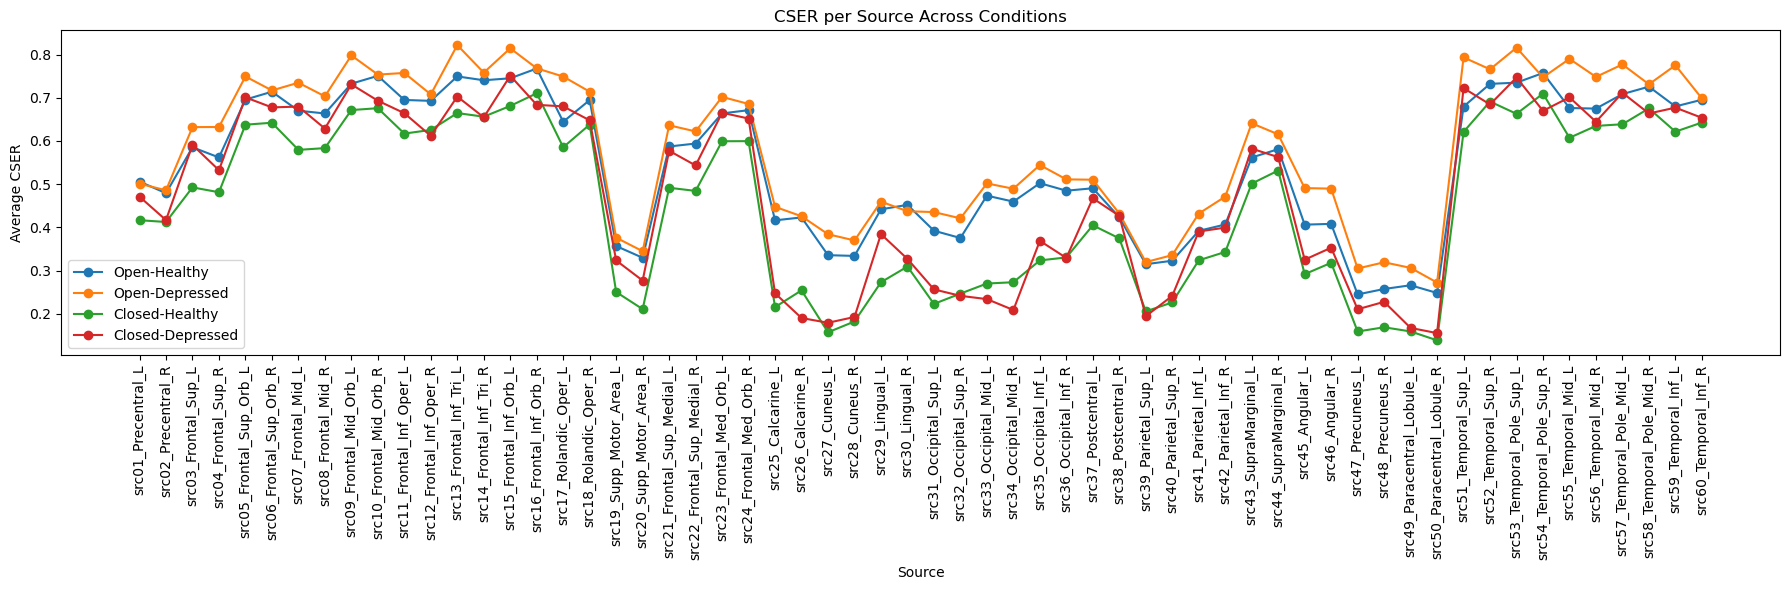

In [67]:
source_indices = np.arange(1, 61)

plt.figure(figsize=(18, 6))
for eyes in ['open', 'closed']:
    for depressed in df['depressed'].unique():
        mask = (df['eyes'] == eyes) & (df['depressed'] == depressed) & (df['band'] == 'broadband')
        avg = df.loc[mask, 'CSER'].groupby(df['area']).mean().reindex([f'src{i+1:02d}_{source_names[i]}' for i in range(60)])
        plt.plot(source_indices, avg, marker='o', label=f'{eyes.capitalize()}-{'Depressed' if depressed else 'Healthy'}')

plt.xticks(source_indices, [f'src{idx+1:02d}_{source_names[idx]}' for idx in range(60)], rotation=90)
plt.xlabel('Source')
plt.ylabel('Average CSER')
plt.title('CSER per Source Across Conditions')
plt.legend()
plt.tight_layout()
plt.show()

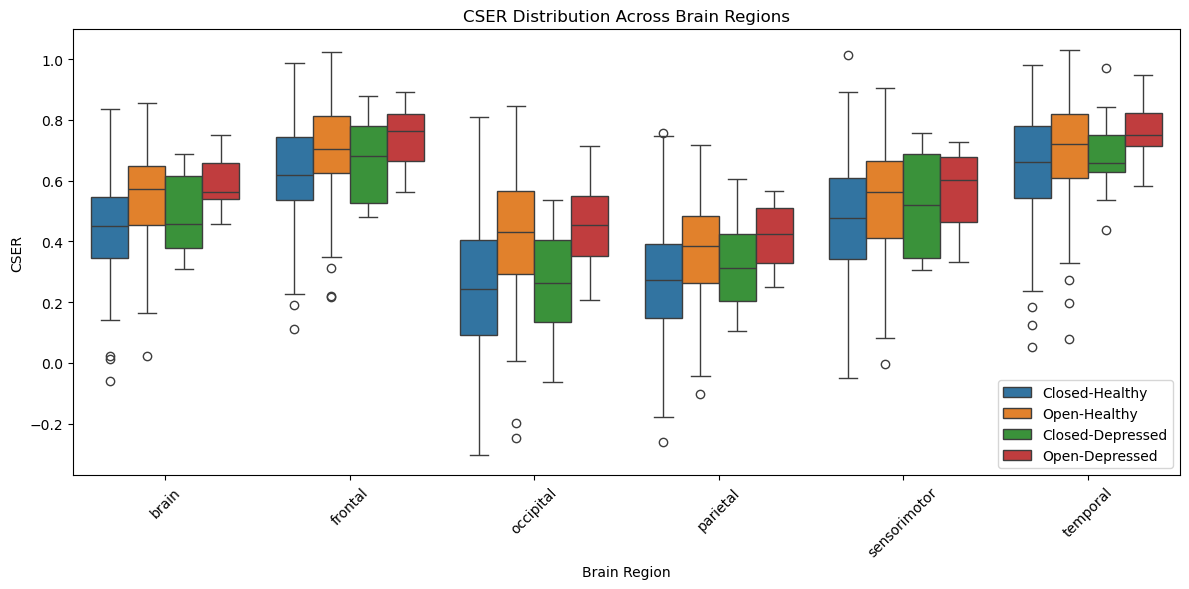

In [68]:
# Plotting CSER distribution across brain regions
mask = (df['band'] == 'broadband') & (~df['area'].str.startswith('src'))
df_regions = df.loc[mask, ['area', 'CSER', 'eyes', 'depressed']].copy()
df_regions['eyes'] = df_regions['eyes'].str.capitalize()
df_regions['depressed'] = df_regions['depressed'].apply(lambda x: 'Depressed' if x == 1 else 'Healthy')
df_regions['condition'] = df_regions['eyes'] + '-' + df_regions['depressed']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_regions, x='area', y='CSER', hue='condition')

plt.xlabel('Brain Region')
plt.ylabel('CSER')
plt.title('CSER Distribution Across Brain Regions')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

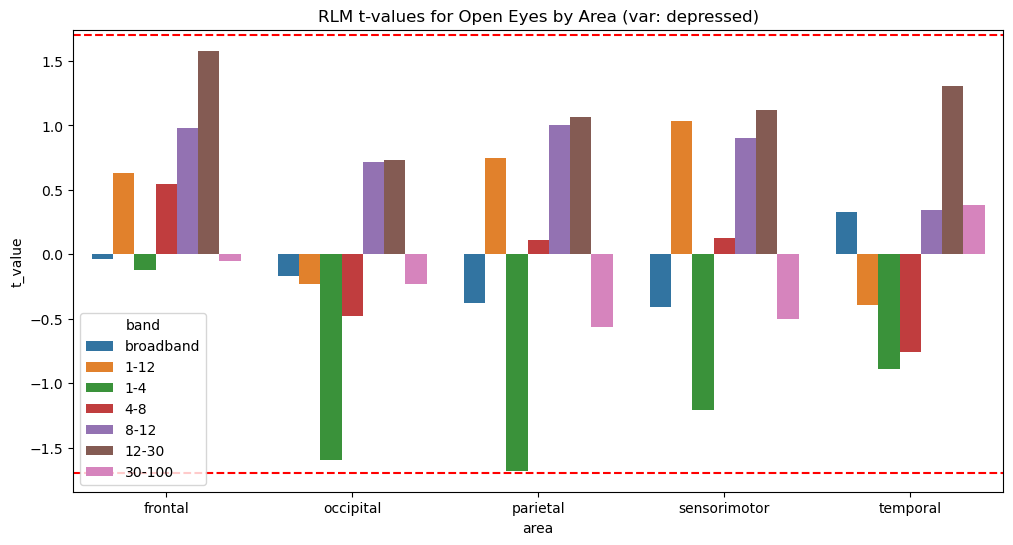

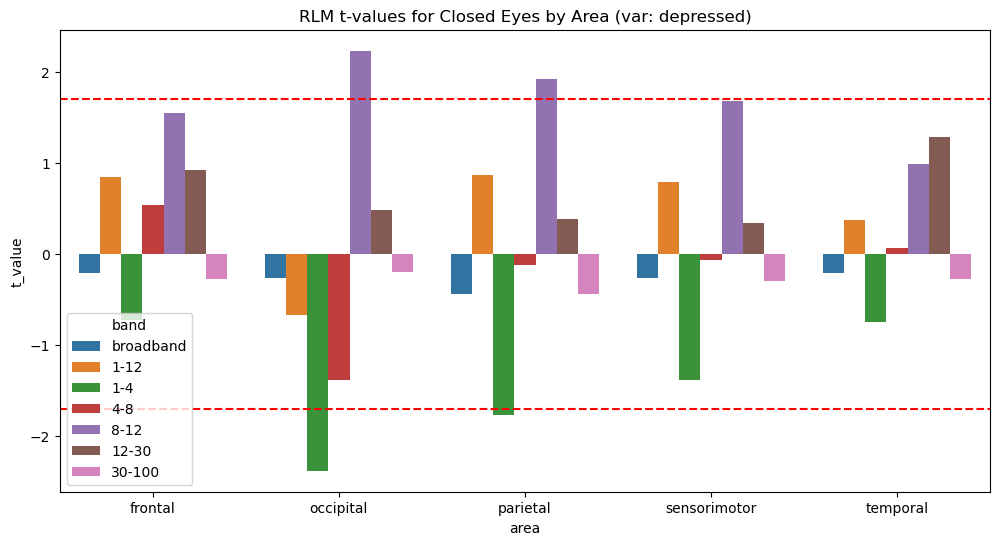

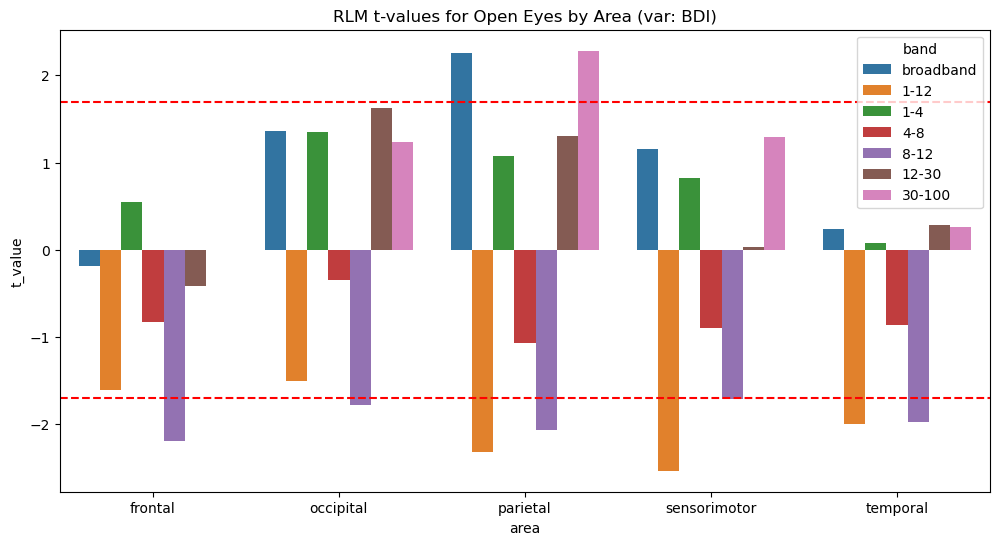

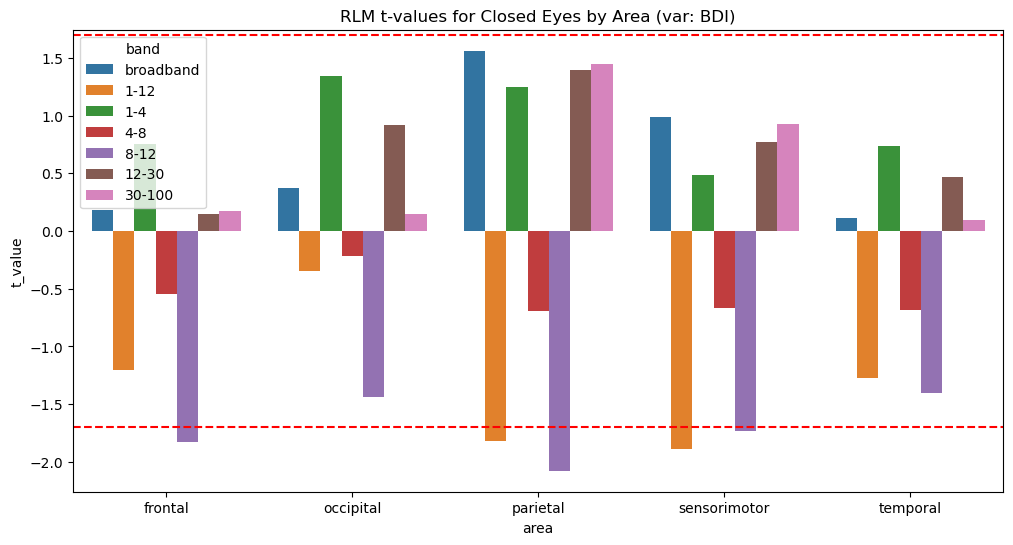

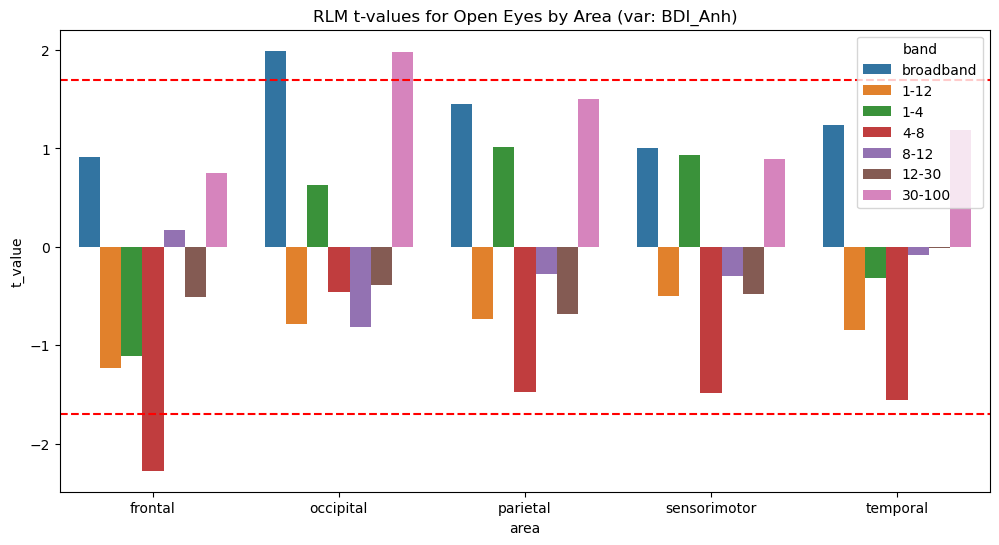

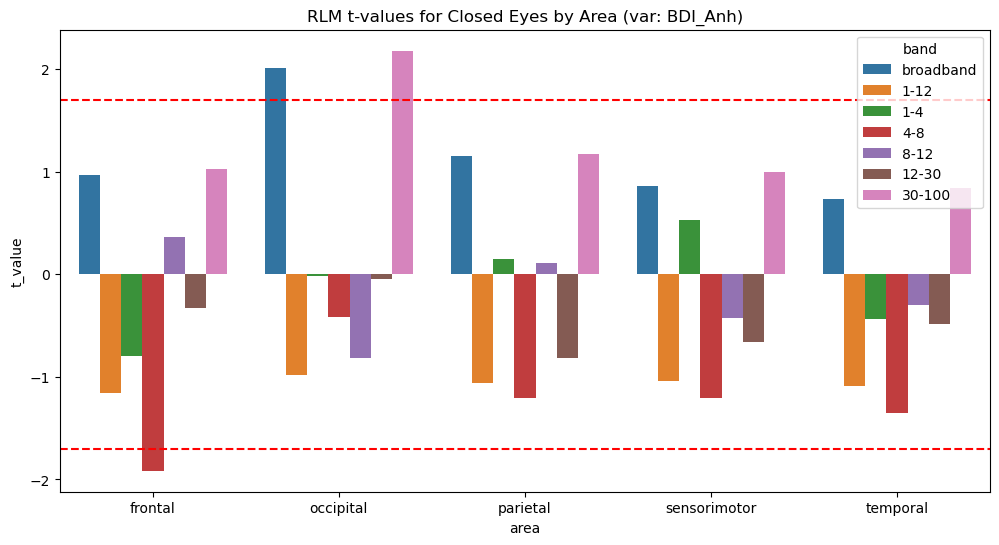

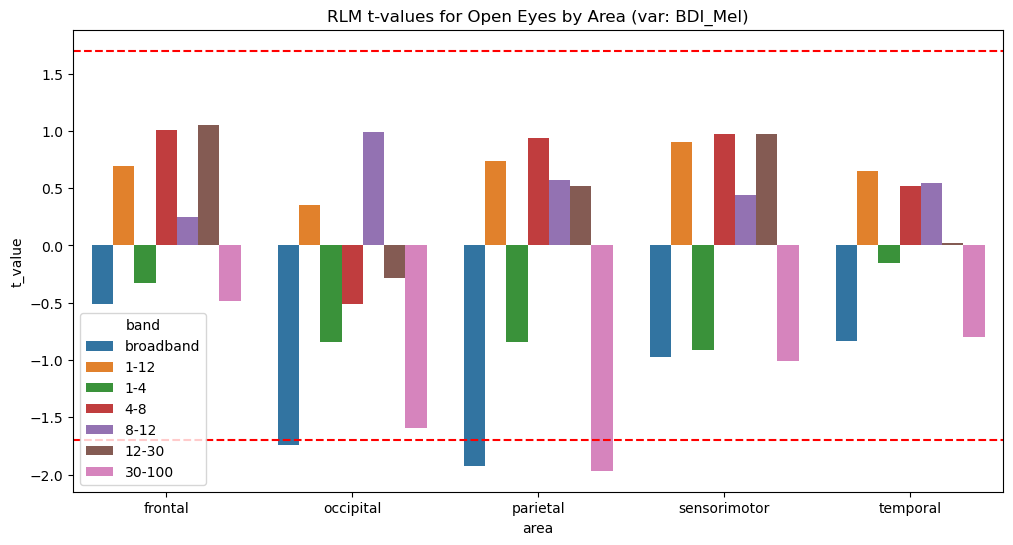

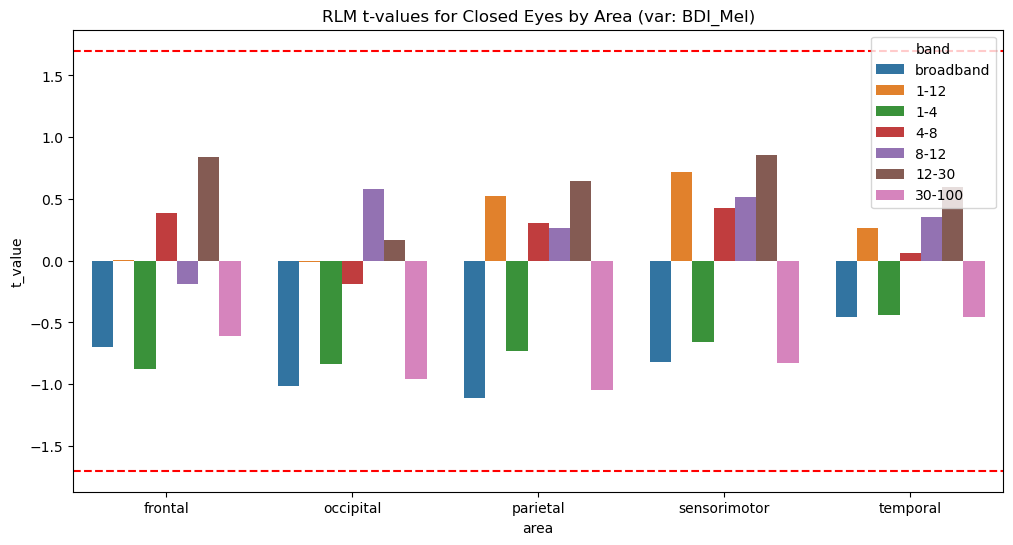

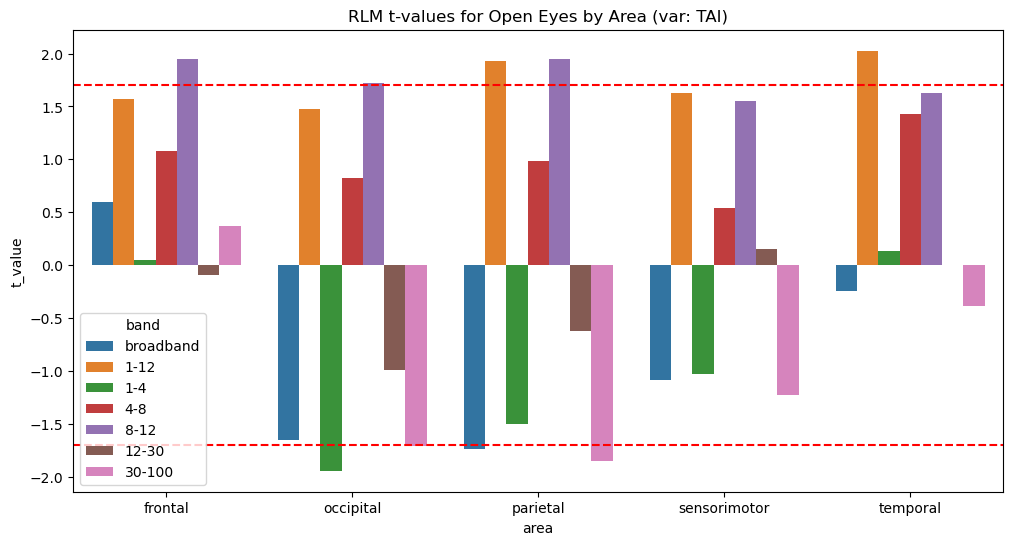

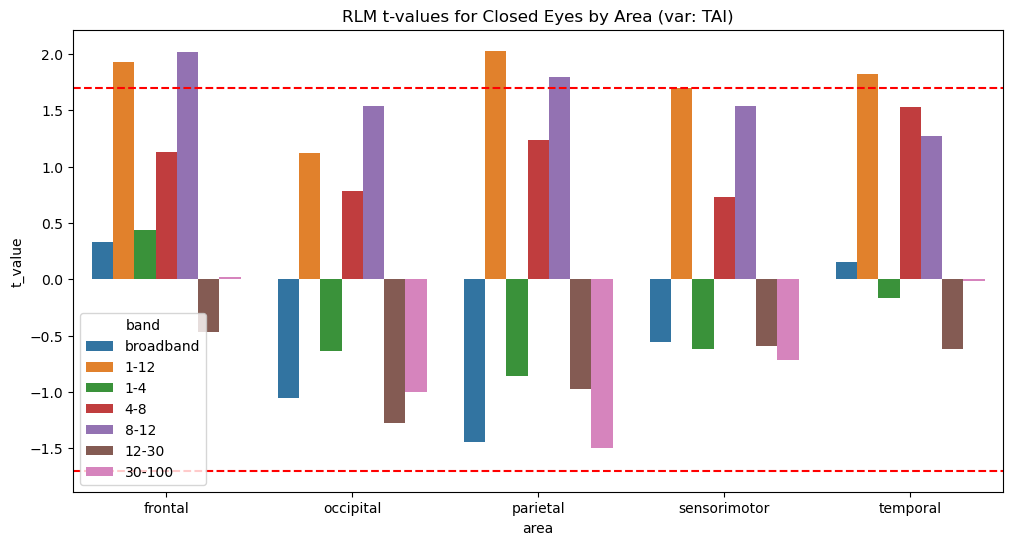

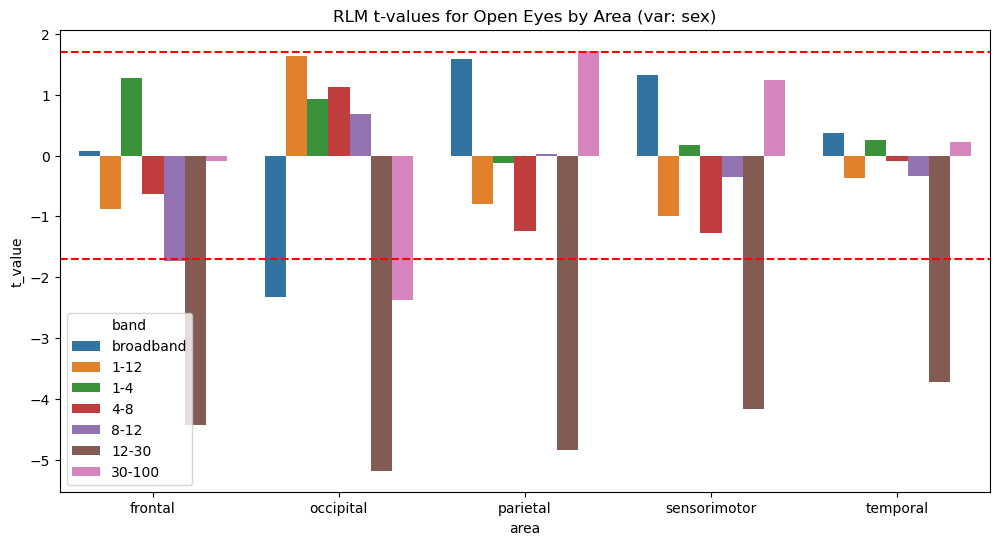

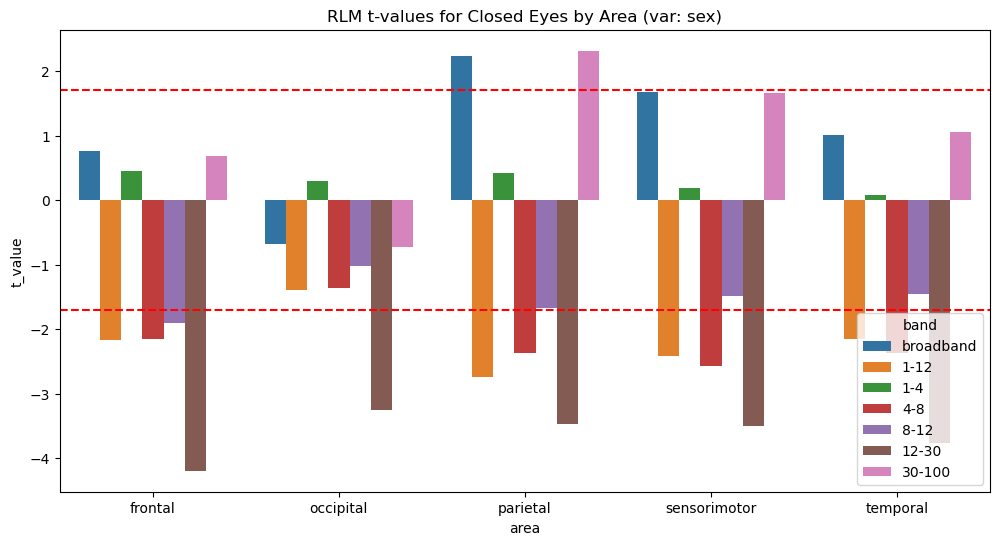

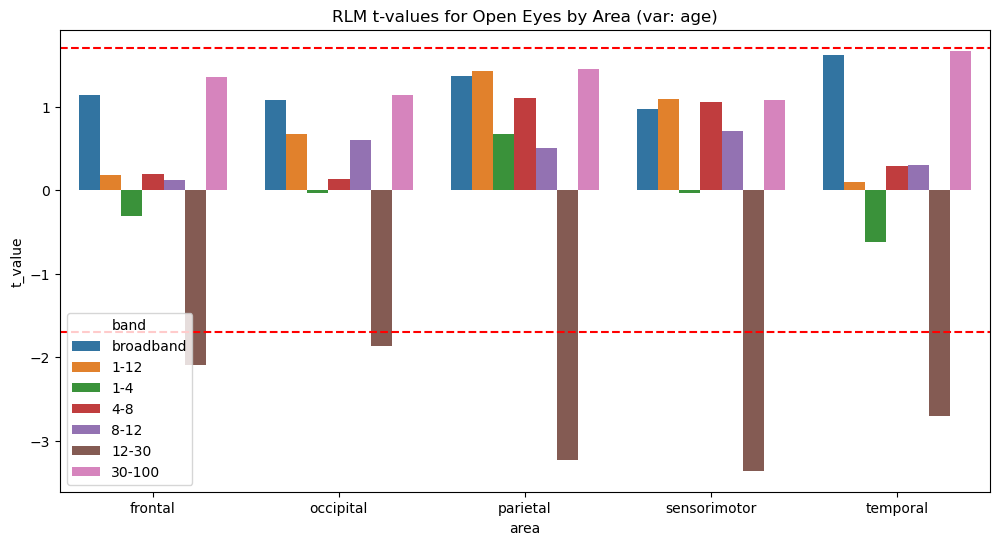

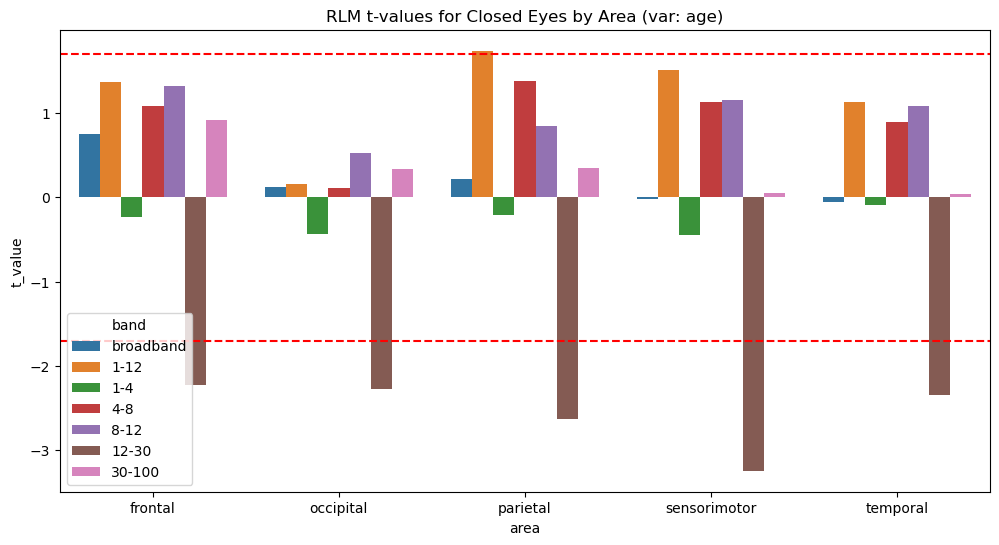

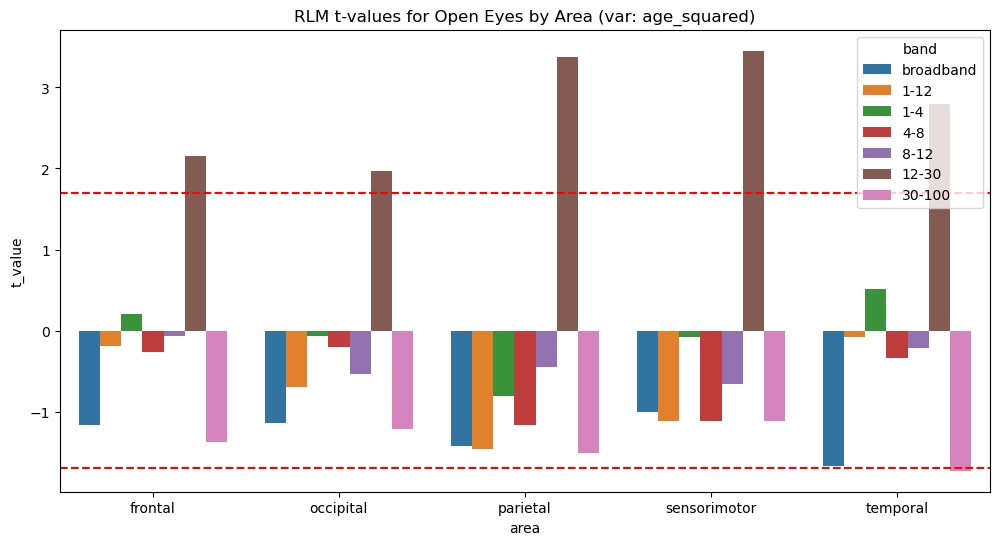

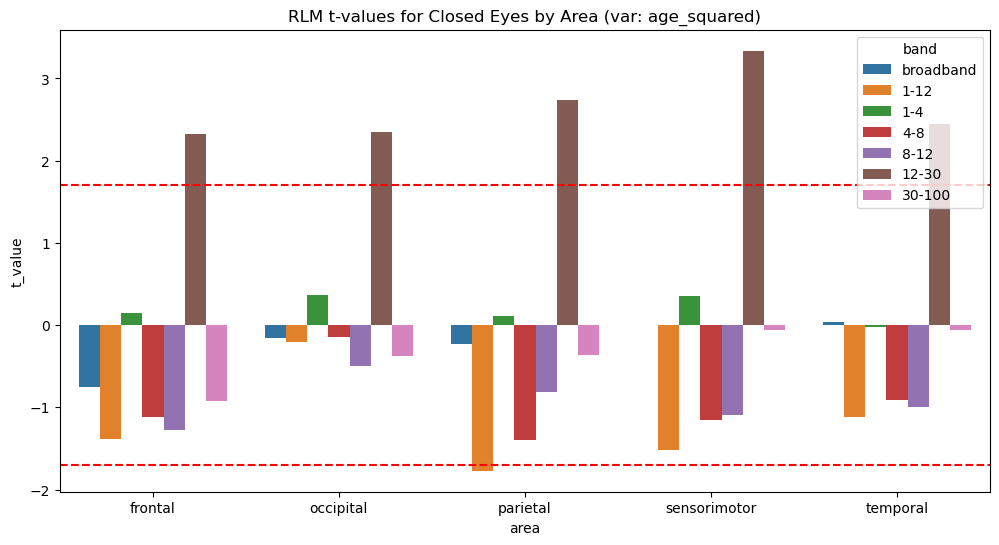

In [101]:
def barplot_significance(eyes, var):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=rlm_results[(rlm_results['eyes'] == eyes) & (rlm_results['variable'] == var) & (rlm_results['area'].isin(region_map.keys()))],
                x='area', y='t_value', hue='band', errorbar=None)
    plt.title(f'RLM t-values for {str.capitalize(eyes)} Eyes by Area (var: {var})')
    plt.axhline(y=1.7, color='r', linestyle='--')
    plt.axhline(y=-1.7, color='r', linestyle='--')
    plt.show()
    

for var in variables:
    if var in ['intercept']:
        continue
    barplot_significance('open', var)
    barplot_significance('closed', var)

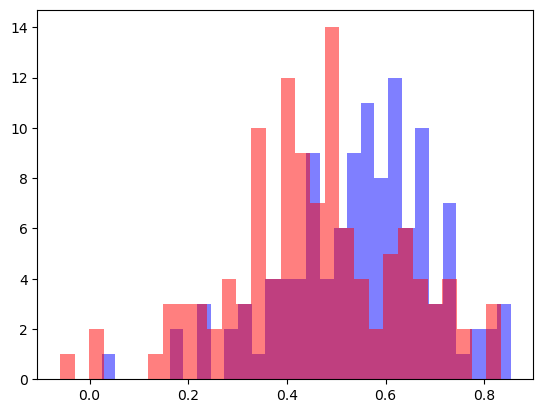

In [ ]:
# Plot the distribution of CSER values with eyes set to 'open' and 'closed'
mask_open = (df['eyes'] == 'open') & (df['area'] == 'brain') & (df['band'] == 'broadband')
mask_closed = (df['eyes'] == 'closed') & (df['area'] == 'brain') & (df['band'] == 'broadband')

plt.hist(df[mask_open]['CSER'].dropna(), bins=30, alpha=0.5, color='blue', label='CSER Open');
plt.hist(df[mask_closed]['CSER'].dropna(), bins=30, alpha=0.5, color='red', label='CSER Closed');

## EXCEL & PICKLE EXPORT

In [ ]:
date_str = datetime.now().strftime("%Y_%m_%d - %H_%M")

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_excel_path = os.path.join(output_dir, f"{date_str}.xlsx")

with pd.ExcelWriter(output_excel_path) as writer:
    cser_mean_band_area.to_excel(writer, sheet_name='CSER / Band / Area')
    cser_mean_band_area_pivot.to_excel(writer, sheet_name='CSER / Band / Area (Pivot)')
    
    cser_mean_band_pivot.to_excel(writer, sheet_name='CSER / Band')
    cser_mean_area_pivot.to_excel(writer, sheet_name='CSER / Area')

    rlm_results.to_excel(writer, sheet_name='RLM Results')
    significant_results.to_excel(writer, sheet_name='Significant Results')

c:\Users\lukad\mne-python\1.9.0_0\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [ ]:
date_str = datetime.now().strftime("%Y_%m_%d - %H_%M")

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_pickle_path = os.path.join(output_dir, f"{date_str}.pkl")

pickle_dict = {
    'cser_mean_band_area': cser_mean_band_area,
    'cser_mean_band_area_pivot': cser_mean_band_area_pivot,
    'cser_mean_band_pivot': cser_mean_band_pivot,
    'cser_mean_area_pivot': cser_mean_area_pivot,
    'rlm_results': rlm_results,
    'significant_results': significant_results
}

with open(output_pickle_path, 'wb') as f:
    pd.to_pickle(pickle_dict, f)